# Imports

In [1]:
import random as rnd
import simpy as sp
import matplotlib.pyplot as plt
import pandas
import datetime
import dateutil
%matplotlib inline

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)

# Appliances 

In [72]:
appliances = pandas.read_csv('./appliances.csv')
appliances.head()

,Apellido,Compromiso Declarado,Miembros,Aparato,Consumo/Dt,Horario alpha,Horario beta,Duracion (horas),Cada N Dias
0,AA,BAJO,2,Calefaccion,1,00:00:00 AM,0,24,1
1,AA,BAJO,2,Frigorifico,1,00:00:00 AM,0,24,1
2,AA,BAJO,2,Tostadora,8,08:00:00 AM,10,1,2
3,AA,BAJO,2,Lavadora,15,01:00:00 PM,100,1,2
4,BB,ALTO,5,Lavadora,10,10:00:00 PM,50,2,1


In [73]:
appliances.describe()

,Miembros,Consumo/Dt,Horario beta,Duracion (horas),Cada N Dias
count,37.000000,37.000000,37.000000,37.000000,37.000000
mean,2.891892,7.729730,30.081081,12.486486,1.243243
std,1.349563,7.981397,39.242394,11.371557,0.547997
min,1.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,0.000000,1.000000,1.000000
50%,2.000000,5.000000,10.000000,3.000000,1.000000
75%,4.000000,12.000000,52.000000,24.000000,1.000000
max,5.000000,32.000000,100.000000,24.000000,3.000000


# Actions

In [74]:
DATETIME_START = datetime.datetime(2014, 12, 31, 0, 0)
class Action:
    def __init__(self, env, appliance,day):
        self.env = env
        self.appliance = appliance
        logging.debug("surname, appliance = %s" % str((self.appliance['Apellido'], self.appliance['Aparato'])))
        self.minimum_datetime = self.generate_datetime(day, 
                                                       self.appliance['Horario alpha'], 
                                                       self.appliance['Horario beta'])
    def _hour2datetime(self, hour=None):
        if not hour:
            hour = self.env.now
        return DATETIME_START + datetime.timedelta(hours=hour)
    def run(self):
        event_datetime = self._hour2datetime()
        while not (self.minimum_datetime <= event_datetime):    
            logging.debug("too early for %s" % str(self.appliance))
            yield self.env.timeout(1)
            event_datetime   = self._hour2datetime()
        for d in range(self.appliance['Duracion (horas)']):
            ce = self.consumption_event(self.appliance)
            yield self.env.timeout(1)
    def generate_datetime(self, day, alpha, beta):
        simulated_hour = dateutil.parser.parse(alpha).hour
        return self._hour2datetime(hour=24*day+simulated_hour)
    def consumption_event(self, appliance):
        current_appliance = self.appliance['Aparato']
        current_family_id = self.appliance['Apellido']
        consumption_event_kwh = appliance['Consumo/Dt']*rnd.normalvariate(1,.2)
        event_datetime   = self._hour2datetime()
        event = { 'datetime':event_datetime, 
                  'surname':current_family_id, 
                  '%s kwh' % current_appliance : consumption_event_kwh }
        recorded_events.append(event)
        logging.debug("event = %s" % str(event))
        return event
    def is_valid(self, day):
        return (day % self.appliance['Cada N Dias'] == 0)

In [75]:
class Family:
    def __init__(self, env, appliances, day):
        self.day_actions = list()
        for appliance in appliances.values():
            a = Action(env, appliance, day)
            if a.is_valid(day):
                self.day_actions.append(a)

# Simulate

In [76]:
recorded_events = list()
env = sp.Environment()
simulated_days = 15

def simulate_day(day):
    for surname in appliances['Apellido'].unique().tolist():
        family_appliances = appliances[appliances['Apellido']==surname].T.to_dict()
        family = Family(env, family_appliances, day)
        for action in family.day_actions:
            env.process(action.run())

for day in range(simulated_days):
    simulate_day(day)

    
env.run()

data = pandas.DataFrame(recorded_events)
#data.columns = [ 'datetime', 'surname', 'kwh', 'appliance' ]
data = data.set_index('datetime')
data.describe()

,Calefaccion kwh,Friegaplatos kwh,Frigorifico kwh,Lavadora kwh,Tostadora kwh
count,2880.000000,15.000000,3600.000000,201.000000,128.000000
mean,1.252011,31.702042,1.306378,16.808521,9.240169
std,0.502392,5.867610,0.543086,6.107607,3.297359
min,0.282329,20.326486,0.390254,6.483515,2.869072
25%,0.912940,29.233639,0.920506,11.478484,6.320833
50%,1.086717,31.840502,1.106595,16.494625,9.208777
75%,1.412360,34.425976,1.638388,21.815578,11.650252
max,3.155289,44.483635,3.226086,30.676649,17.641852


In [77]:
data.head(10)

,Calefaccion kwh,Friegaplatos kwh,Frigorifico kwh,Lavadora kwh,Tostadora kwh,surname
datetime,,,,,,
2014-12-31,1.225340,NaN,NaN,NaN,NaN,AA
2014-12-31,NaN,NaN,1.054233,NaN,NaN,AA
2014-12-31,0.931774,NaN,NaN,NaN,NaN,BB
2014-12-31,NaN,NaN,0.850122,NaN,NaN,BB
2014-12-31,NaN,NaN,2.519626,NaN,NaN,CC
2014-12-31,0.986959,NaN,NaN,NaN,NaN,DD
2014-12-31,NaN,NaN,1.628554,NaN,NaN,DD
2014-12-31,0.994903,NaN,NaN,NaN,NaN,EE
2014-12-31,NaN,NaN,1.193583,NaN,NaN,EE


In [78]:
data['dt'] = data.index

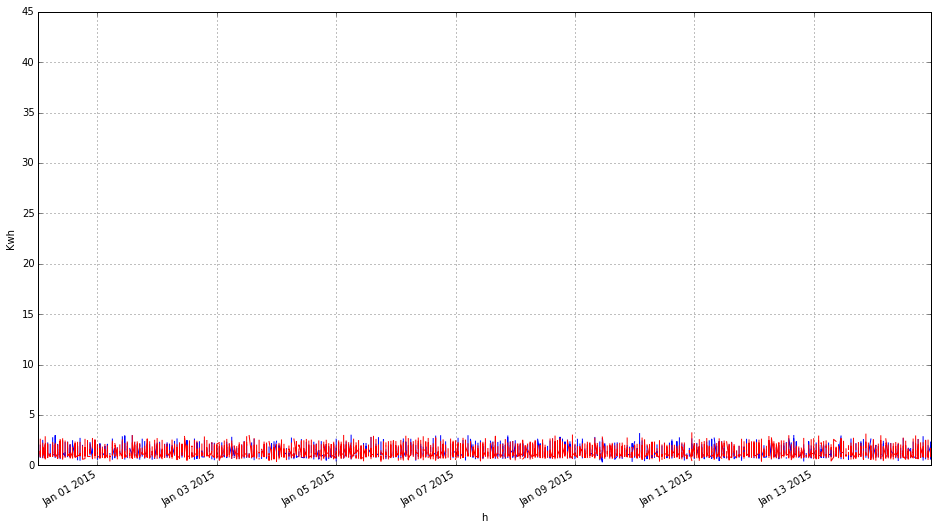

In [79]:
f = plt.figure()
ax = data.plot(x='dt', figsize=(16,9), legend=None)
ax.set_ylabel("Kwh")
ax.set_xlabel("h")

# Costes

### Parametrización del coste cada hora

Sacado de: 
<http://www.esios.ree.es/preciodiario/>

se muestra el array creado(a ojo de la página a día 24/06/2015

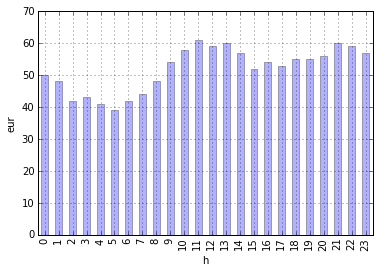

In [80]:
costs = [50,48,42,43,41,39,42,44,48,54,58,61,59,60,57,52,54,53,55,55,56,60,59,57]
hours = range(0, 24)

#costs_df = pandas.DataFrame(zip(costs*days,[  d for d in range(days*24) ]))
costs_df = pandas.DataFrame(zip(costs, hours))
costs_df.columns = ['costs', 'hours', ]
ax = costs_df.plot(x='hours', y='costs', kind='bar', legend=None, alpha=0.3)
ax.set_ylabel('eur')
ax.set_xlabel('h')

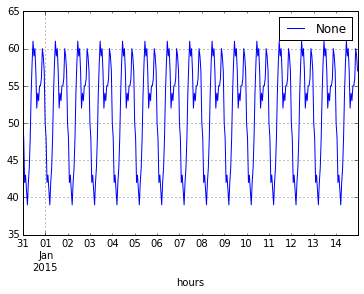

In [81]:
costs = [50,48,42,43,41,39,42,44,48,54,58,61,59,60,57,52,54,53,55,55,56,60,59,57]
hours = range(0, 24)
days = 15

#costs_df = pandas.DataFrame(zip(costs*days,[  d for d in range(days*24) ]))
costs_df = pandas.DataFrame(zip(costs*days,
                                [  DATETIME_START + datetime.timedelta(hours=d) for d in range(simulated_days*24) ]))

costs_df.columns = [ 'costs', 'hours' ]
costs_df = costs_df.set_index('hours')
costs_df['hours'] = costs_df.index
costs_df.plot(x='hours', y='costs') #rects1 = ax.bar(hours, costs, 1, color='r')

## Cálculo coste hora

In [82]:
data.head()

,Calefaccion kwh,Friegaplatos kwh,Frigorifico kwh,Lavadora kwh,Tostadora kwh,surname,dt
datetime,,,,,,,
2014-12-31,1.225340,NaN,NaN,NaN,NaN,AA,2014-12-31
2014-12-31,NaN,NaN,1.054233,NaN,NaN,AA,2014-12-31
2014-12-31,0.931774,NaN,NaN,NaN,NaN,BB,2014-12-31
2014-12-31,NaN,NaN,0.850122,NaN,NaN,BB,2014-12-31
2014-12-31,NaN,NaN,2.519626,NaN,NaN,CC,2014-12-31


In [83]:
eur_data = data.join(costs_df, rsuffix='cost_')

In [84]:
eur_data.head()

,Calefaccion kwh,Friegaplatos kwh,Frigorifico kwh,Lavadora kwh,Tostadora kwh,surname,dt,costs,hours
2014-12-31,1.225340,NaN,NaN,NaN,NaN,AA,2014-12-31,50,2014-12-31
2014-12-31,NaN,NaN,1.054233,NaN,NaN,AA,2014-12-31,50,2014-12-31
2014-12-31,0.931774,NaN,NaN,NaN,NaN,BB,2014-12-31,50,2014-12-31
2014-12-31,NaN,NaN,0.850122,NaN,NaN,BB,2014-12-31,50,2014-12-31
2014-12-31,NaN,NaN,2.519626,NaN,NaN,CC,2014-12-31,50,2014-12-31


In [85]:
for c in eur_data.columns:
    if c.endswith(' kwh'):
        eur_data[c+' eur'] = eur_data[c]*eur_data['costs']

In [91]:
eur_data.describe()

,Calefaccion kwh,Friegaplatos kwh,Frigorifico kwh,Lavadora kwh,Tostadora kwh,costs,Calefaccion kwh eur,Friegaplatos kwh eur,Frigorifico kwh eur,Lavadora kwh eur,Tostadora kwh eur
count,2880.000000,15.000000,3600.000000,201.000000,128.000000,6824.000000,2880.000000,15.000000,3600.000000,201.000000,128.000000
mean,1.252011,31.702042,1.306378,16.808521,9.240169,52.042937,65.017227,1482.033056,67.854252,897.922615,505.185984
std,0.502392,5.867610,0.543086,6.107607,3.297359,6.817510,27.655530,311.757191,29.793497,319.139703,218.166857
min,0.282329,20.326486,0.390254,6.483515,2.869072,39.000000,15.528083,853.712413,17.262688,358.472742,126.239165
25%,0.912940,29.233639,0.920506,11.478484,6.320833,48.000000,45.941341,1325.783235,46.667546,625.941830,316.952601
50%,1.086717,31.840502,1.106595,16.494625,9.208777,54.000000,57.387159,1509.659763,58.237994,900.986891,499.624004
75%,1.412360,34.425976,1.638388,21.815578,11.650252,58.000000,74.714206,1598.261723,82.371597,1120.182866,662.896348
max,3.155289,44.483635,3.226086,30.676649,17.641852,61.000000,178.923796,2224.181729,185.922091,1690.563513,1058.511099


In [94]:
median_family = eur_data.describe().ix[5]

['Calefaccion kwh eur', 'Friegaplatos kwh eur', 'Frigorifico kwh eur', 'Lavadora kwh eur', 'Tostadora kwh eur']


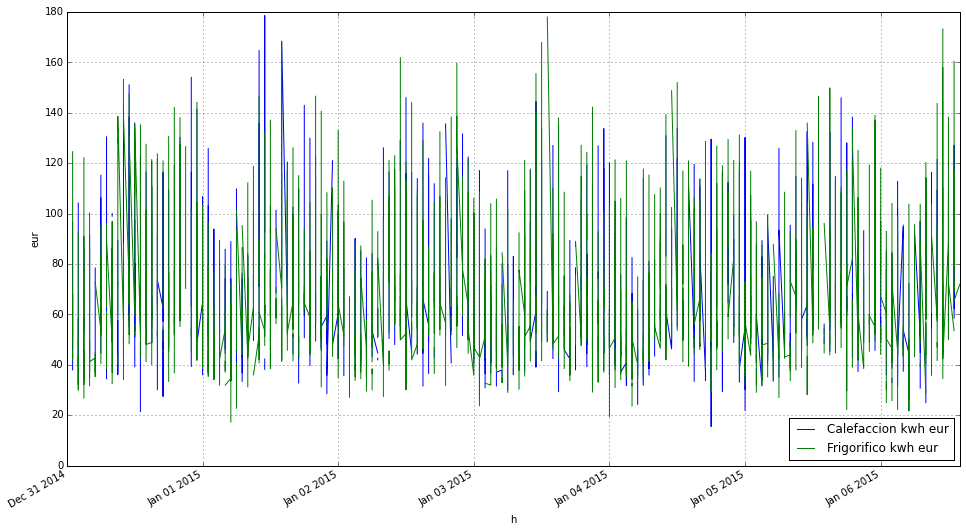

In [95]:
cost_cols = [c for c in eur_data.columns if c.endswith(' eur')]
print cost_cols
ax = eur_data[['Calefaccion kwh eur', 'Frigorifico kwh eur']].head(3000).plot(figsize=(16,9))
ax.set_xlabel('h')
ax.set_ylabel('eur')

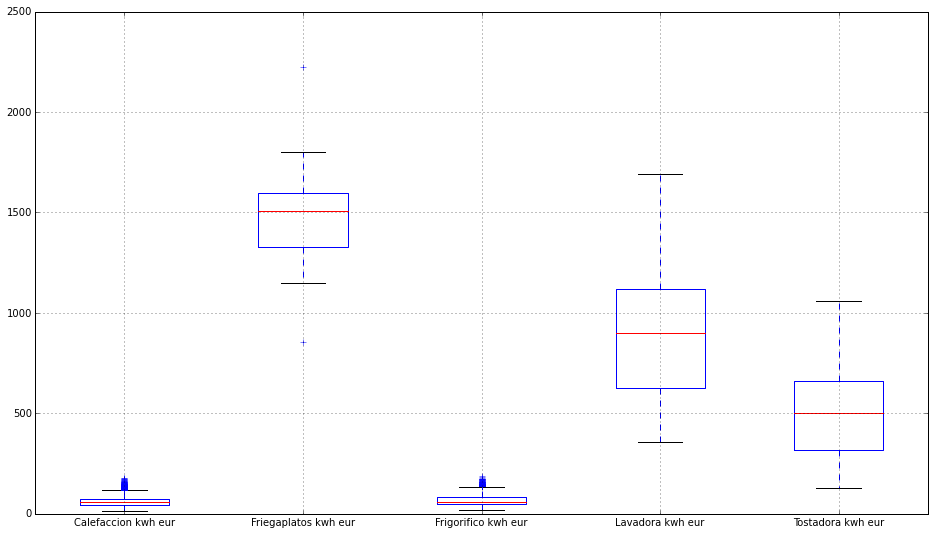

In [96]:
f = plt.figure(figsize=(16,9))
ax1 = plt.subplot(111)
bp = eur_data.boxplot(column=cost_cols, ax=ax1)

In [107]:
medians = eur_data.groupby('surname').median()
medians = medians.append(median_family)
medians.index.name='surname'
medians

,Calefaccion kwh,Friegaplatos kwh,Frigorifico kwh,Lavadora kwh,Tostadora kwh,costs,Calefaccion kwh eur,Friegaplatos kwh eur,Frigorifico kwh eur,Lavadora kwh eur,Tostadora kwh eur
surname,,,,,,,,,,,
AA,0.998736,NaN,1.002415,12.976408,7.918267,54,51.951104,NaN,51.606322,778.584459,380.076813
BB,0.976127,NaN,0.981471,9.812061,NaN,54,50.917500,NaN,51.026563,568.954793,NaN
CC,NaN,NaN,2.020414,11.054582,5.379868,55,NaN,NaN,103.991705,633.683818,322.792106
DD,1.008877,NaN,2.068981,21.935070,13.016506,54,51.324704,NaN,104.415389,1176.600630,794.006896
EE,1.010527,NaN,0.985372,14.107403,7.128275,54,51.427443,NaN,50.189198,550.188731,313.644093
FF,1.993186,NaN,0.998645,23.381212,NaN,54,102.530776,NaN,51.801668,920.641449,NaN
GG,1.029272,31.840502,0.994201,11.082988,5.273045,54,52.464459,1509.659763,51.284387,609.564339,232.013986
HH,0.991515,NaN,0.986561,17.852795,12.139362,54,50.726035,NaN,51.407447,1062.480940,728.361739
II,1.984926,NaN,2.012602,20.787839,10.725902,54,102.408585,NaN,102.884752,1229.381862,528.365990


In [116]:
AAmedians = medians[medians.index.map(lambda i:i in ['AA','50%'])]
AAmedians

,Calefaccion kwh,Friegaplatos kwh,Frigorifico kwh,Lavadora kwh,Tostadora kwh,costs,Calefaccion kwh eur,Friegaplatos kwh eur,Frigorifico kwh eur,Lavadora kwh eur,Tostadora kwh eur
surname,,,,,,,,,,,
AA,0.998736,NaN,1.002415,12.976408,7.918267,54,51.951104,NaN,51.606322,778.584459,380.076813
50%,1.086717,31.840502,1.106595,16.494625,9.208777,54,57.387159,1509.659763,58.237994,900.986891,499.624004


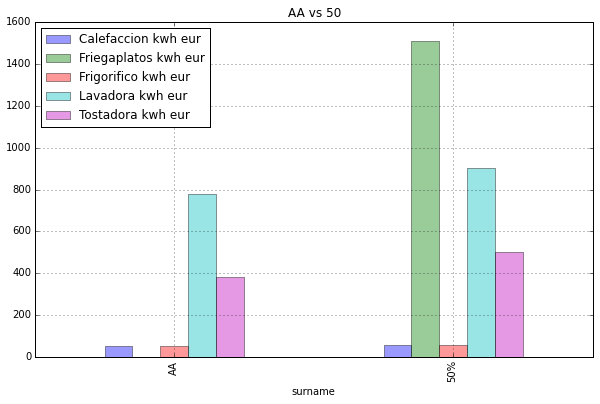

In [123]:
AAmedians.plot(y=cost_cols,kind='bar',alpha=0.4, figsize=(10,6),title='AA vs 50')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d275c90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10d93c7d0>]], dtype=object)

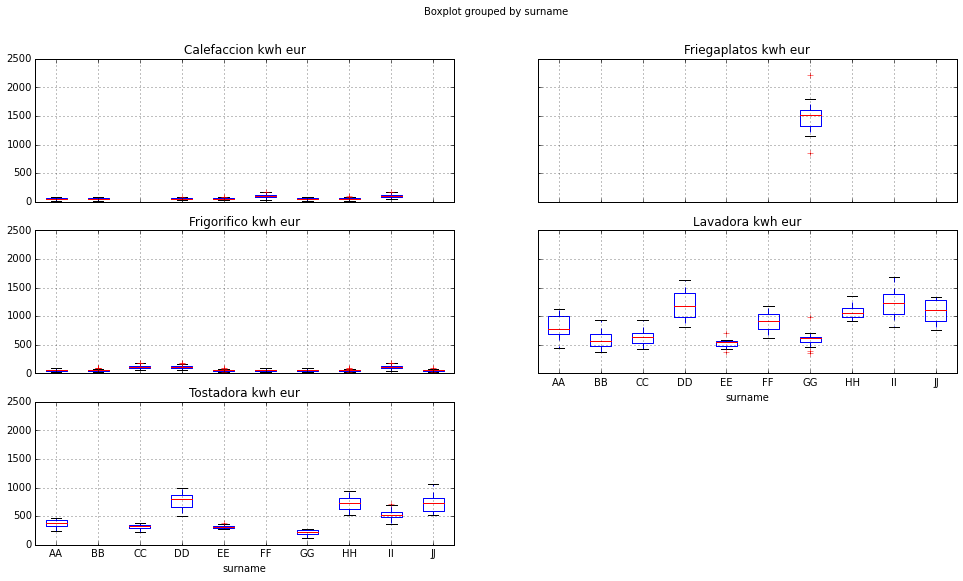

In [89]:
f = plt.figure(figsize=(16,9))
ax1 = plt.subplot(121)
bp = eur_data.boxplot(column=cost_cols, ax=ax1)
color = dict(boxes='DarkGreen', whiskers='DarkOrange',
             medians='DarkBlue', caps='Gray')
ax2 = plt.subplot(122)
eur_data.boxplot(by='surname', column=cost_cols, ax=ax2, sym='r+')

In [ ]:
eur_data[cost_cols].head(2000).plot(kind='area', figsize=(16,9))

In [53]:
pandas.version.version

'0.15.2'

In [54]:
data.shape

(6824, 7)

In [55]:
eur_data[cost_cols].replace('nan', 0.0).to_csv('consumos3n.csv')